In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio
from datetime import date, timedelta
import calendar
import datetime as dt
from tqdm import tqdm
import math

In [2]:
#read in phenology data for each species
#downloaded from the Phenology Observation Network on 24-Jan-2020
#these incuded New England and also surrounding areas to try to include climatic range beyond New England
beech = pd.read_csv('~/Insight/Foliage/Datasheets/beech/status_intensity_observation_data.csv')
beech2 = pd.read_csv('~/Insight/Foliage/Datasheets/beech2/status_intensity_observation_data.csv')
hickory = pd.read_csv('~/Insight/Foliage/Datasheets/hickory/status_intensity_observation_data.csv')
hickory2 = pd.read_csv('~/Insight/Foliage/Datasheets/hickory2/status_intensity_observation_data.csv')
sorbus = pd.read_csv('~/Insight/Foliage/Datasheets/sorbus/status_intensity_observation_data.csv')
sorbus2 = pd.read_csv('~/Insight/Foliage/Datasheets/sorbus2/status_intensity_observation_data.csv')
acer = pd.read_csv('~/Insight/Foliage/Datasheets/acer/status_intensity_observation_data.csv')
acer2 = pd.read_csv('~/Insight/Foliage/Datasheets/acer2/status_intensity_observation_data.csv')
quercus = pd.read_csv('~/Insight/Foliage/Datasheets/quercus/status_intensity_observation_data.csv')
quercus2 = pd.read_csv('~/Insight/Foliage/Datasheets/quercus2/status_intensity_observation_data.csv')
birch = pd.read_csv('~/Insight/Foliage/Datasheets/birch/status_intensity_observation_data.csv')
birch2 = pd.read_csv('~/Insight/Foliage/Datasheets/birch2/status_intensity_observation_data.csv')
other = pd.read_csv('~/Insight/Foliage/Datasheets/other/status_intensity_observation_data.csv')
other2 = pd.read_csv('~/Insight/Foliage/Datasheets/other2/status_intensity_observation_data.csv')
all_data = pd.concat([acer, acer2, quercus, quercus2, beech, beech2, birch, birch2, hickory, hickory2, sorbus, sorbus2, other, other2])
all_data.shape

/Users/elizabethspriggs/miniconda2/envs/autumncast-modeling/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/elizabethspriggs/miniconda2/envs/autumncast-modeling/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (8,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2442912, 44)

In [3]:
#See which phenophases are best represented in the dataset
all_data.groupby(['Phenophase_ID','Phenophase_Name']).Observation_ID.count()

Phenophase_ID  Phenophase_Name          
180            >75% of full leaf size         5742
               >=75% of full leaf size        2716
181            >50% of leaves colored        15096
               >=50% of leaves colored        2378
               Autumn color                    102
182            All leaves colored            17553
183            >50% of leaves fallen         15404
               >=50% of leaves fallen         2393
               Leaf fall                       104
184            All leaves fallen             17737
186            Full Flowering                 7710
               Full flowering                 1899
196            Full pollen release             839
201            Open flowers                     63
202            Ripe fruits                      63
232            Emerging leaves                  63
233            Young unfolded leaves            63
371            Breaking leaf buds           233644
               Emerging leaves           

In [4]:
autumn_IDs = (181, 182, 498)
all_data[all_data.Phenophase_ID.isin(autumn_IDs)].Common_Name.value_counts().head()

red maple           55624
American beech      35084
sugar maple         33952
northern red oak    27313
pignut hickory      14220
Name: Common_Name, dtype: int64

In [5]:
#Extract only the autumn records
autumn_all = all_data[all_data.Phenophase_Status == 1]
autumn_all = autumn_all[autumn_all.Phenophase_ID.isin(autumn_IDs)]
autumn_all.Phenophase_ID.value_counts()

498    60292
181      731
182      569
Name: Phenophase_ID, dtype: int64

In [6]:
#choose only the observations with 25-100% fall color
all_over25 = autumn_all[(autumn_all.Intensity_Category_ID.isin([14, 42, 74])) &
            (autumn_all.Intensity_Value.isin(['25-49%', '50-74%', '75-94%', '95% or more']))]

#remove any observations before the 241th day of the year (Sept 1st or Aug 31 in leap years)
#this excludes trees that might have colored leaves earlier in the year because they are sick or dying
all_over25 = all_over25[all_over25.Day_of_Year >= 241]
print(all_over25.State.value_counts().head())
all_over25.Intensity_Value.unique()

NY    9554
MA    7383
NH    2254
ME    1507
MI     932
Name: State, dtype: int64


array(['75-94%', '25-49%', '50-74%', '95% or more'], dtype=object)

In [7]:
#use only the 20 most common species:
keep_species = all_over25.Common_Name.value_counts()[:20].index.tolist()
filtered_df = all_over25[all_over25.Common_Name.isin(keep_species)]
print(len(filtered_df))
#print(keep_species)

21724


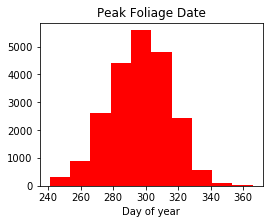

In [8]:
#make histogram of the data
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.hist(filtered_df.Day_of_Year, color = 'red')
ax.set_title('Peak Foliage Date')
ax.set_xlabel('Day of year')
plt.show()

In [9]:
#save a CSV with only the filtered data and only the relevant features
all_save = filtered_df[['Observation_ID', 'State', 'Latitude', 'Longitude','Site_Name', 'Species_ID', 
                              'Common_Name', 'Species', 'Phenophase_Description', 'Observation_Date', 
                              'Day_of_Year', 'Phenophase_Status', 'Intensity_Category_ID', 'Intensity_Value']]
all_save.to_csv('clean_phenology_all.csv')

len(all_save.Observation_ID)

21724

In [10]:
data = pd.read_csv('clean_phenology_all.csv')
len(data)

21724

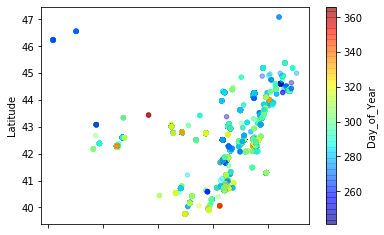

In [11]:
#quick plot to see the geographic distribution of the points (not preojcted)
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4, c="Day_of_Year", cmap=plt.get_cmap("jet"))
plt.show()

In [13]:
data.head()

,Unnamed: 0,Observation_ID,State,Latitude,Longitude,Site_Name,Species_ID,Common_Name,Species,Phenophase_Description,Observation_Date,Day_of_Year,Phenophase_Status,Intensity_Category_ID,Intensity_Value
0,1208,801251.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2011-09-12,255.0,1.0,14.0,75-94%
1,1209,801272.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2011-10-26,299.0,1.0,14.0,25-49%
2,1260,2735493.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2013-10-24,297.0,1.0,42.0,25-49%
3,7198,1565041.0,ME,43.08535,-70.69133,Home,61,sugar maple,saccharum,Colored leaves,2012-10-08,282.0,1.0,42.0,50-74%
4,7221,2652107.0,ME,43.08535,-70.69133,Home,61,sugar maple,saccharum,Colored leaves,2013-09-30,273.0,1.0,42.0,50-74%


In [14]:
#add a separte year feature
time = pd.to_datetime(data['Observation_Date'], errors = 'coerce')
year_list = time.dt.year.reset_index(name = 'Year')
data2 = pd.concat([data, year_list.Year], axis = 1)

data2.head()

,Unnamed: 0,Observation_ID,State,Latitude,Longitude,Site_Name,Species_ID,Common_Name,Species,Phenophase_Description,Observation_Date,Day_of_Year,Phenophase_Status,Intensity_Category_ID,Intensity_Value,Year
0,1208,801251.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2011-09-12,255.0,1.0,14.0,75-94%,2011
1,1209,801272.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2011-10-26,299.0,1.0,14.0,25-49%,2011
2,1260,2735493.0,ME,43.08535,-70.69133,Home,3,red maple,rubrum,Colored leaves,2013-10-24,297.0,1.0,42.0,25-49%,2013
3,7198,1565041.0,ME,43.08535,-70.69133,Home,61,sugar maple,saccharum,Colored leaves,2012-10-08,282.0,1.0,42.0,50-74%,2012
4,7221,2652107.0,ME,43.08535,-70.69133,Home,61,sugar maple,saccharum,Colored leaves,2013-09-30,273.0,1.0,42.0,50-74%,2013


In [15]:
#for each species, each year, each location, find the mean 'day of the year'
counts = data2.groupby(['Latitude', 'Longitude', 'Year','Common_Name']).size().reset_index(name = 'counts')
locations = data2.groupby(['Latitude', 'Longitude', 'Year','Common_Name']).Day_of_Year.mean().reset_index(name = 'day_mean')
day_std = data2.groupby(['Latitude', 'Longitude', 'Year','Common_Name']).Day_of_Year.std().reset_index(name = 'day_std')
meansdf = locations.merge(counts)
meansdf = meansdf.merge(day_std)
print('Total number of observations:', len(meansdf))
print('Locations, year, species with more than 5 observations:', len(meansdf[meansdf.counts >= 5]))
print(meansdf.head())
meansdf.to_csv('means_data.csv')

Total number of observations: 1751
Locations, year, species with more than 5 observations: 956
    Latitude  Longitude  Year   Common_Name    day_mean  counts    day_std
0  39.747726 -77.569374  2014     red maple  302.000000       1        NaN
1  39.747726 -77.569374  2015       pin oak  320.928571      14  18.590586
2  39.747726 -77.569374  2015     red maple  306.875000       8  13.367738
3  39.747726 -77.569374  2019     red maple  289.000000       1        NaN
4  39.758430 -77.507004  2015  Norway maple  293.333333       3   5.507571


In [16]:
#look at standard deviations by species
more_samples = meansdf[meansdf.counts >= 20]
more_samples.groupby('Common_Name').day_std.mean()

Common_Name
American beech           11.576396
American mountain ash    12.858365
Norway maple             16.103061
bear oak                  9.512181
black oak                12.539014
flowering dogwood        21.391122
gray dogwood              9.501041
northern red oak         12.832185
paper birch              13.447555
pignut hickory           10.587864
pin oak                   9.673162
red maple                12.360340
silver maple             17.220121
striped maple             6.985577
sugar maple              13.130905
sweetgum                 11.626400
tuliptree                16.888362
white ash                 9.648282
white oak                13.496489
yellow birch              7.388454
Name: day_std, dtype: float64

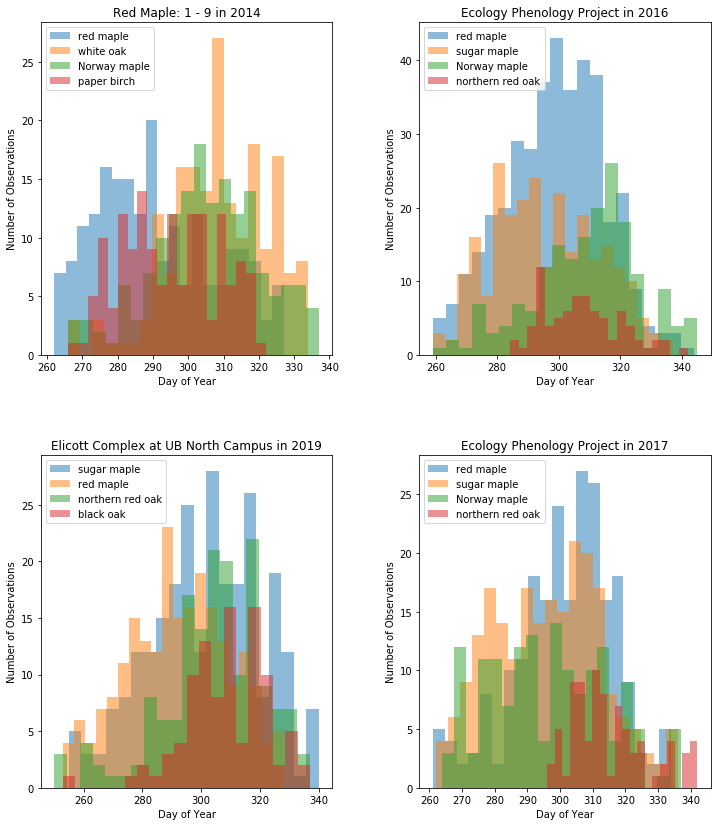

In [17]:
#To look at whether there are obvious differences between species
#select the locations with the most data, then make histograms for the 4 most 
#common species at each location

#keep_Species = all_clean.Common_Name.value_counts()[:20].index.tolist()
locations = data2.groupby(['Latitude', 'Longitude', 'Year']).size().reset_index(name = 'counts')
toplocations = locations.sort_values(by = ['counts'], ascending = False).head(4)

fig = plt.figure(figsize=(12,30))
fig.subplots_adjust(wspace = .3, hspace =.3)
i = 1
for index, row in toplocations.iterrows():
    location0 = data2[(data2['Latitude'] == row.Latitude) & 
                     (data2['Longitude'] == row.Longitude) &
                     (data2['Year'] == row.Year)]
    top_spp = location0.Common_Name.value_counts()[:4].index.tolist()
    location0_spp = location0[location0['Common_Name'].isin(top_spp)]
    
    spp0 = location0_spp[location0_spp.Common_Name == top_spp[0]]
    spp1 = location0_spp[location0_spp.Common_Name == top_spp[1]]
    spp2 = location0_spp[location0_spp.Common_Name == top_spp[2]]
    spp3 = location0_spp[location0_spp.Common_Name == top_spp[3]]
    
    ax = fig.add_subplot(4,2,i)
    ax.hist(spp0.Day_of_Year, alpha = 0.5, label = top_spp[0], bins = 20)
    ax.hist(spp1.Day_of_Year, alpha = 0.5, label = top_spp[1], bins = 20)
    ax.hist(spp2.Day_of_Year, alpha = 0.5, label = top_spp[2], bins = 20)
    ax.hist(spp3.Day_of_Year, alpha = 0.5, label = top_spp[3], bins = 20)
    ax.set_title('{} in {}'.format(spp0.Site_Name.iloc[0], toplocations.Year.iloc[i-1]))
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Number of Observations')    
    ax.legend(loc = 'upper left')
    i += 1    

### Download PRISM data and combine single day files to make one file per year

In [ ]:
#https://github.com/sdtaylor/pyPRISMClimate#pyprismclimateget_prism_dailys
#pip install git+git://github.com/sdtaylor/pyPRISMClimate
#this takes about 40 minutes for one years data for a single variable

#for a single year:
from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single, get_prism_dailys, get_prism_normals
get_prism_dailys('tmin', min_date = '2010-01-01', max_date = '2010-12-31', 
                 dest_path = '/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2', keep_zip=False)

In [ ]:
#download PRISM daily data 2010 onward minimum temperature
min_dates = ['2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01']
max_dates = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31']

for i in range(0,8):
    #download PRISM daily data 2011 onward
    from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single, get_prism_dailys, get_prism_normals
    get_prism_dailys('tmin', min_date = min_dates[i], max_date = max_dates[i], 
                 dest_path = '/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM', keep_zip=False)

    print(min_dates[i])
    print(max_dates[i])

In [ ]:
#same thing for precipitation data:
min_dates = ['2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01']
max_dates = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31']

for i in range(0,len(min_dates)):
    #download PRISM daily data 2010 onward
    from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single, get_prism_dailys, get_prism_normals
    get_prism_dailys('ppt', min_date = min_dates[i], max_date = max_dates[i], 
                 dest_path = '/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2', keep_zip=False)

    print(min_dates[i])
    print(max_dates[i])

In [ ]:
#download PRISM daily data 2010 onward for maximum temperature
min_dates = ['2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01']
max_dates = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31']

for i in range(0,len(min_dates)):
    #download PRISM daily data 2011 onward
    from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single, get_prism_dailys, get_prism_normals
    get_prism_dailys('tmax', min_date = min_dates[i], max_date = max_dates[i], 
                 dest_path = '/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2', keep_zip=False)

    print(min_dates[i])
    print(max_dates[i])

In [ ]:
#create function to stack the raster files for each year:
#from https://github.com/mapbox/rasterio/issues/1273
def stack(band_paths, out_path, return_raster=True):
    """Stack a set of bands into a single file.
    
    Parameters
    ----------
    bands : list of file paths
        A list with paths to the bands you wish to stack. Bands
        will be stacked in the order given in this list.
    out_path : string
        A path for the output file.
    return_raster : bool
        Whether to return a refernce to the opened output
        raster file.
    """
    # Read in metadata
    first_band = rasterio.open(band_paths[0], 'r')
    meta = first_band.meta.copy()

    # Replace metadata with new count and create a new file
    counts = 0
    for ifile in band_paths:
        with rasterio.open(ifile, 'r') as ff:
            counts += ff.meta['count']
    meta.update(count=counts)
    with rasterio.open(out_path, 'w', **meta) as ff:
        for ii, ifile in tqdm(enumerate(band_paths)):
            bands = rasterio.open(ifile, 'r').read()
            if bands.ndim != 3:
                bands = bands[np.newaxis, ...]
            for band in bands:
                ff.write(band, ii+1)

    if return_raster is True:
        return rasterio.open(out_path)

In [ ]:
#change each of the rasters into a dictionary
#https://gis.stackexchange.com/questions/306098/loading-all-rasters-in-a-directory-and-naming-the-variables-iteratively
d={} #create dictionary to store all of the years
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for the_year in years:
    
    # handle leap years
    if calendar.isleap(the_year):
        days = 366
    else:
        days = 365
    
    # first day of the year you're working on
    the_day = date(year=the_year, month=1, day=1)
    # a time interval of one day
    one_day = timedelta(days=1)

    d["bands{0}".format(the_year)] = []

    while the_day.year == the_year:
        path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_tmin_stable_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d"))
        if os.path.exists(path):
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day
        else:
            path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_tmin_provisional_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d")) 
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day

In [ ]:
#then save the dictionary to  a raster stack
stack(d["bands2010"], out_path='tmin_2010.bil', return_raster=False)
stack(d["bands2011"], out_path='tmin_2011.bil', return_raster=False)
stack(d["bands2012"], out_path='tmin_2012.bil', return_raster=False)
stack(d["bands2013"], out_path='tmin_2013.bil', return_raster=False)
stack(d["bands2014"], out_path='tmin_2014.bil', return_raster=False)
stack(d["bands2015"], out_path='tmin_2015.bil', return_raster=False)
stack(d["bands2016"], out_path='tmin_2016.bil', return_raster=False)
stack(d["bands2017"], out_path='tmin_2017.bil', return_raster=False)
stack(d["bands2018"], out_path='tmin_2018.bil', return_raster=False)
stack(d["bands2019"], out_path='tmin_2019.bil', return_raster=False)

In [ ]:
#stack the precipitation data too
d={} #create dictionary to store all of the years
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for the_year in years:
    
    # handle leap years
    if calendar.isleap(the_year):
        days = 366
    else:
        days = 365
    
    # first day of the year you're working on
    the_day = date(year=the_year, month=1, day=1)
    # a time interval of one day
    one_day = timedelta(days=1)

    d["bands{0}".format(the_year)] = []

    while the_day.year == the_year:
        path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_ppt_stable_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d"))
        if os.path.exists(path):
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day
        else:
            path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_ppt_provisional_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d")) 
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day

In [ ]:
#then save it as a raster stack
stack(d["bands2010"], out_path='ppt_2010.bil', return_raster=False)
stack(d["bands2011"], out_path='ppt_2011.bil', return_raster=False)
stack(d["bands2012"], out_path='ppt_2012.bil', return_raster=False)
stack(d["bands2013"], out_path='ppt_2013.bil', return_raster=False)
stack(d["bands2014"], out_path='ppt_2014.bil', return_raster=False)
stack(d["bands2015"], out_path='ppt_2015.bil', return_raster=False)
stack(d["bands2016"], out_path='ppt_2016.bil', return_raster=False)
stack(d["bands2017"], out_path='ppt_2017.bil', return_raster=False)
stack(d["bands2018"], out_path='ppt_2018.bil', return_raster=False)
stack(d["bands2019"], out_path='ppt_2019.bil', return_raster=False)

In [ ]:
#stack the tmax data 
d={} #create dictionary to store all of the years
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for the_year in years:
    
    # handle leap years
    if calendar.isleap(the_year):
        days = 366
    else:
        days = 365
    
    # first day of the year you're working on
    the_day = date(year=the_year, month=1, day=1)
    # a time interval of one day
    one_day = timedelta(days=1)

    d["bands{0}".format(the_year)] = []

    while the_day.year == the_year:
        path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_tmax_stable_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d"))
        if os.path.exists(path):
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day
        else:
            path = "/Users/elizabethspriggs/Insight/Foliage/Datasheets/PRISM2/PRISM_tmax_provisional_4kmD2_{}_bil.bil".format(the_day.strftime("%Y%m%d")) 
            d["bands{0}".format(the_year)].append(path)
            the_day = the_day + one_day

In [ ]:
#then save it as a raster stack
stack(d["bands2010"], out_path='tmax_2010.bil', return_raster=False)
stack(d["bands2011"], out_path='tmax_2011.bil', return_raster=False)
stack(d["bands2012"], out_path='tmax_2012.bil', return_raster=False)
stack(d["bands2013"], out_path='tmax_2013.bil', return_raster=False)
stack(d["bands2014"], out_path='tmax_2014.bil', return_raster=False)
stack(d["bands2015"], out_path='tmax_2015.bil', return_raster=False)
stack(d["bands2016"], out_path='tmax_2016.bil', return_raster=False)
stack(d["bands2017"], out_path='tmax_2017.bil', return_raster=False)
stack(d["bands2018"], out_path='tmax_2018.bil', return_raster=False)
stack(d["bands2019"], out_path='tmax_2019.bil', return_raster=False)

In [ ]:
#plot a raster lyer 
with rasterio.open('Datasheets/stacked_PRISM/tmin_2019.bil', 'r') as src:
    img = src.read(200) #the 200th day of that year (July 19th)
    img[img == -9999] = np.nan  # Convert NoData to NaN
    vmin, vmax = np.nanpercentile(img, (5,95))  # 5-95% stretch

    fig = plt.figure(figsize=(20,20))    
plot = show(img, cmap='viridis', title= 'Min Temp July 19')
    

In [ ]:
#plot another date
with rasterio.open('Datasheets/stacked_PRISM/tmin_2019.bil', 'r') as src:
#    show(src)
    img = src.read(10) #January 10th
    img[img == -9999] = np.nan  # Convert NoData to NaN
    vmin, vmax = np.nanpercentile(img, (5,95))  # 5-95% stretch
    #these only have one band

fig = plt.figure(figsize=(20,20))    
plot = show(img, cmap='viridis', title= 'Min Temp January 10')
    

In [ ]:
#see raster metadata
with rasterio.open('Datasheets/stacked_PRISM/tmin_2019.bil', 'r') as raster:
    print(raster.meta)

### Feature Engineering:

For each location, extract temperature and precipitiation from raster files, then calculate relevant summary statistics

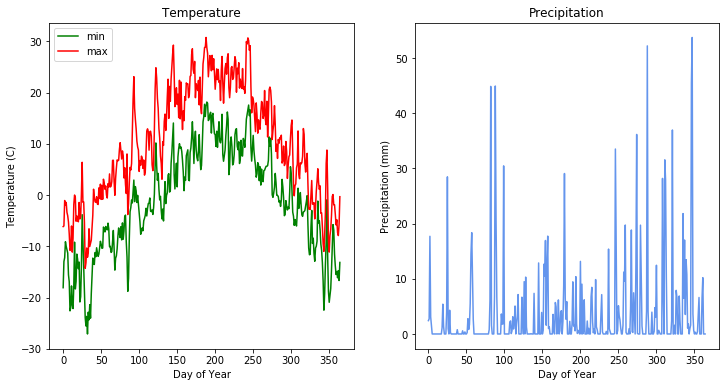

In [18]:
#first a test of this -- extract temperature and precipitation 
#information for a specific location in a specific year

x = -68.95469978573749
y = 46.015724399999996
tmin = []
tmax = []
ppt = []
year = 2010
#day_of_year = 365

# handle leap years
if calendar.isleap(year):
    day_of_year = 366
else:
    day_of_year = 365

with rasterio.open("../Datasheets/stacked_PRISM/tmin_{}.bil".format(year)) as raster:
    for val in raster.sample([(x, y)], indexes = range(1,day_of_year+1)): tmin.append(val)
tmin = np.asarray(tmin)
tmin = tmin.transpose()
days = np.array(range(0, day_of_year))

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(days, tmin, color = 'green', label = 'min')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature')


with rasterio.open('../Datasheets/stacked_PRISM/tmax_{}.bil'.format(year)) as p_raster:
    for val in p_raster.sample([(x, y)], indexes = range(1,day_of_year+1)): tmax.append(val)
tmax = np.asarray(tmax)
tmax = tmax.transpose()

ax.plot(days, tmax, color = 'red', label = 'max')
ax.legend(loc = 'upper left')


with rasterio.open('../Datasheets/stacked_PRISM/ppt_{}.bil'.format(year)) as p_raster:
    for val in p_raster.sample([(x, y)], indexes = range(1,day_of_year+1)): ppt.append(val)
ppt = np.asarray(ppt)
ppt = ppt.transpose()

ax2 = fig.add_subplot(122)
ax2.plot(days, ppt, color = 'cornflowerblue')
ax2.set_title('Precipitation')
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Precipitation (mm)')


plt.show()

In [19]:
print(x, y, year)

-68.95469978573749 46.015724399999996 2010


In [20]:
#daylength function from: https://gist.github.com/anttilipp/ed3ab35258c7636d87de6499475301ce
def daylength(dayOfYear, lat):
    """Computes the length of the day (the time between sunrise and
    sunset) given the day of the year and latitude of the location.
    Function uses the Brock model for the computations.
    For more information see, for example,
    Forsythe et al., "A model comparison for daylength as a
    function of latitude and day of year", Ecological Modelling,
    1995.
    Parameters
    ----------
    dayOfYear : int
        The day of the year. 1 corresponds to 1st of January
        and 365 to 31st December (on a non-leap year).
    lat : float
        Latitude of the location in degrees. Positive values
        for north and negative for south.
    Returns
    -------
    d : float
        Daylength in hours.
    """
    latInRad = np.deg2rad(lat)
    declinationOfEarth = 23.45*np.sin(np.deg2rad(360.0*(283.0+dayOfYear)/365.0))
    if -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) <= -1.0:
        return 24.0
    elif -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) >= 1.0:
        return 0.0
    else:
        hourAngle = np.rad2deg(np.arccos(-np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth))))
        return 2.0*hourAngle/15.0

In [21]:
#Create a function that does the feature engineering based on location 
#(Latitude, Longitude) and year

def foliage_prediction(x, y, InYear):
    tmin = []
    tmax = []
    ppt = []
    year = pd.to_datetime(InYear).year
    #print('predicting for: ', x, y, 'in ', year)
    if calendar.isleap(year):
        day_of_year = 366
        Fdays = 29
    else:
        day_of_year = 365
        Fdays = 28

    #pull data for that location, that year
    with rasterio.open("/Users/elizabethspriggs/Insight/Foliage/Datasheets/stacked_PRISM/tmin_{}.bil".format(year)) as raster:
        for val in raster.sample([(x, y)], indexes = range(1,day_of_year+1)): tmin.append(val)

    #pull data for that location, that year
    with rasterio.open("/Users/elizabethspriggs/Insight/Foliage/Datasheets/stacked_PRISM/tmax_{}.bil".format(year)) as raster:
        for val in raster.sample([(x, y)], indexes = range(1,day_of_year+1)): tmax.append(val)            
            
    #pull data for that location, that year
    with rasterio.open("/Users/elizabethspriggs/Insight/Foliage/Datasheets/stacked_PRISM/ppt_{}.bil".format(year)) as raster:
        for val in raster.sample([(x, y)], indexes = range(1,day_of_year+1)): ppt.append(val)

    #Get the day of the first frost:
    below_zero = np.where(tmin[0] < 0)
    first_frost = below_zero[0][below_zero[0] > 200][0]
    var1 = first_frost

    #Get the day of the fifth frost:
    #not all of the locations will have a fifth frost before Dec 31st
    below_zero = np.where(tmin[0] < 0)
    try:
        fifth_frost = below_zero[0][below_zero[0] > 200][4]
    except:
        fifth_frost = day_of_year
    var2 = fifth_frost

    #Average minimum temperature in September:
    start = date(year=year, month=9, day=1)
    end = date(year=year, month=9, day=30)
    S_tmp = tmin[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var3 = S_tmp

    #Average minimum temperature in October:
    start = date(year=year, month=10, day=1)
    end = date(year=year, month=10, day=31)
    O_tmp = tmin[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var4 = O_tmp
    
    #Average minimum temperature in November:
    start = date(year=year, month=11, day=1)
    end = date(year=year, month=11, day=30)
    N_tmp = tmin[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var5 = N_tmp

    #Average maximum temperature in July and August:
    start = date(year=year, month=7, day=1)
    end = date(year=year, month=8, day=31)
    JA_max = tmax[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var6 = JA_max

    #Average precipitation in July and August:
    start = date(year=year, month=7, day=1)
    end = date(year=year, month=8, day=31)
    JA_ppt = ppt[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var7 = JA_ppt

    #Average precipitation in September:
    start = date(year=year, month=9, day=1)
    end = date(year=year, month=9, day=30)
    S_ppt = ppt[0][start.timetuple().tm_yday:end.timetuple().tm_yday].mean()
    var8 = S_ppt
    
    #Daylength of September 1st
    start = date(year=year, month=9, day=1)
    day = start.timetuple().tm_yday
    var9 = daylength(day, y)

    #Daylength of November 1st
    start = date(year=year, month=11, day=1)
    day = start.timetuple().tm_yday
    var10 = daylength(day, y)

    return(var1, var2, var3, var4, var5, var6, var7, var8, var9, var10)




In [22]:
#test for an example record:
foliage_prediction(x, y, '2013')

(259,
 295,
 6.7253447,
 1.0097333,
 -7.1055512,
 23.082262,
 3.1068692,
 4.4873104,
 13.131281598236908,
 9.842227014765891)

### Read in means data, calcuate the features for the model:

In [23]:
data = pd.read_csv('means_data.csv', index_col = [0])
data.head()

,Latitude,Longitude,Year,Common_Name,day_mean,counts,day_std
0,39.747726,-77.569374,2014,red maple,302.000000,1,NaN
1,39.747726,-77.569374,2015,pin oak,320.928571,14,18.590586
2,39.747726,-77.569374,2015,red maple,306.875000,8,13.367738
3,39.747726,-77.569374,2019,red maple,289.000000,1,NaN
4,39.758430,-77.507004,2015,Norway maple,293.333333,3,5.507571


In [24]:
Frame = pd.DataFrame(columns = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10'])
for index, row in data.iterrows():
    x = row.Longitude 
    y = row.Latitude
    year = row.Year
    features = foliage_prediction(x,y,str(year))
    Frame = Frame.append({'var1': features[0], 
              'var2': features[1],
             'var3': features [2],
             'var4': features[3],
             'var5': features[4],
             'var6': features[5],
             'var7': features[6],
             'var8': features[7],
             'var9': features[8],
             'var10': features[9]}, ignore_index = True)
#print(Frame.head())
Edata = pd.concat([data, Frame], axis = 1)
Edata.head()

,Latitude,Longitude,Year,Common_Name,day_mean,counts,day_std,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,39.747726,-77.569374,2014,red maple,302.000000,1,NaN,311.0,319.0,12.926172,8.762300,0.261172,27.435165,3.816279,1.814483,12.906835,10.276417
1,39.747726,-77.569374,2015,pin oak,320.928571,14,18.590586,290.0,324.0,15.002828,6.216567,3.820897,28.832998,1.799410,2.507759,12.906835,10.276417
2,39.747726,-77.569374,2015,red maple,306.875000,8,13.367738,290.0,324.0,15.002828,6.216567,3.820897,28.832998,1.799410,2.507759,12.906835,10.276417
3,39.747726,-77.569374,2019,red maple,289.000000,1,NaN,305.0,313.0,15.299345,9.031834,-0.548655,30.049755,3.498590,0.486034,12.906835,10.276417
4,39.758430,-77.507004,2015,Norway maple,293.333333,3,5.507571,290.0,312.0,14.061414,5.379034,3.343448,27.441246,2.503935,4.182069,12.907182,10.275751


In [25]:
#remove locations that don't have data -- these were in Canada, beyond the range of the raster data
print(Edata[Edata.var3 <= -999])
Edata = Edata[Edata.var3 >= -999]

       Latitude  Longitude  Year     Common_Name  day_mean  counts  day_std  \
1283  43.438046 -80.875816  2019  American beech     362.0       2      0.0   
1284  43.438046 -80.875816  2019    silver maple     362.0       1      NaN   

       var1   var2    var3    var4    var5    var6    var7    var8       var9  \
1283  201.0  205.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  13.033274   
1284  201.0  205.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  13.033274   

          var10  
1283  10.032403  
1284  10.032403  


In [26]:
print(len(Edata))
Edata.to_csv('E_means_data.csv')

1749


### Find the most common tree species in each county using the Forest Inventory & Analysis Database:

In [27]:
#For each state, create a list of the dominant tree in every county, also 
#include the number of FIA plots where that species is the most common
#Data is at: https://apps.fs.usda.gov/fia/datamart/CSV/datamart_csv.html

NE_dataframe = pd.DataFrame(columns = ['COUNTYFIP', 'Dominant_Species', 'dominant_plots'])

tree_files = ['../Datasheets/FIA_data/VT_TREE.csv','../Datasheets/FIA_data/CT_TREE.csv', '../Datasheets/FIA_data/ME_TREE.csv','../Datasheets/FIA_data/NH_TREE.csv','../Datasheets/FIA_data/MA_TREE.csv','../Datasheets/FIA_data/RI_TREE.csv']
plot_files = ['../Datasheets/FIA_data/VT_PLOT.csv','../Datasheets/FIA_data/CT_PLOT.csv','../Datasheets/FIA_data/ME_PLOT.csv','../Datasheets/FIA_data/NH_PLOT.csv','../Datasheets/FIA_data/MA_PLOT.csv','../Datasheets/FIA_data/RI_PLOT.csv']

plot_total = 0

for tree, plot in zip(tree_files, plot_files):
    tree_df = pd.read_csv(tree)
    plot_df = pd.read_csv(plot)
    
    plot_total = plot_total + len(tree_df.CN.unique()) #get a list of the number of plots (some are samples multiple years)

    #Get the most common species in each plot:
    common_spp = tree_df.groupby('PLT_CN').SPCD.agg(lambda x:x.value_counts().index[0]).reset_index(name = 'Dominant_Species')
    
    #Merge the most common species with the plot dataset 
    combined = pd.merge(plot_df, common_spp, left_on = 'CN', right_on = 'PLT_CN')
    
    #get the county FIP code from the State and County names:
    a = combined.STATECD
    b = combined.COUNTYCD
    counties = ["{}{:03}".format(a_, b_) for a_,b_ in zip(a,b)]

    COUNTYFIP = pd.DataFrame({'COUNTYFIP':counties})
    combined2 = pd.concat([combined, COUNTYFIP], axis=1)
    
    county_species = combined2[['COUNTYFIP', 'Dominant_Species']]
    county_species2 = county_species.groupby('COUNTYFIP').Dominant_Species.value_counts().reset_index(name = 'dominant_plots')
    
    #Include the four most common species in each county:
    county_major_species = county_species2.groupby('COUNTYFIP').head(4)
        
    NE_dataframe = pd.concat([NE_dataframe, county_major_species])
print(NE_dataframe.head(10))
print('total number of trees:', plot_total)

#NE_dataframe.to_csv('County_species.csv')

/Users/elizabethspriggs/miniconda2/envs/autumncast-modeling/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   COUNTYFIP Dominant_Species dominant_plots
0      50001              318             91
1      50001              531             35
2      50001              316             27
3      50001              261             21
26     50003              531            105
27     50003              318            103
28     50003              316             74
29     50003               12             26
47     50005               12             75
48     50005              318             64
total number of trees: 1348924


In [28]:
#translate the species codes in the FIA database into species names that match the phenology data:
dictionary = {318: 'sugar maple', 531: 'American beech',
              12:'balsam fir', 541:'white ash', 316:'red maple', 
              129:'eastern white pine', 126:'pitch pine', 
              261:'eastern hemlock', 833: 'northern red oak', 
             372: 'sweet birch', 837:'black oak', 97: 'red spruce',
             802:'black cherry', 806: 'scarlet oak', 241:'northern white cedar',
             541:'white ash', 371:'yellow birch', 693:'black gum', 
             375:'paper birch', 762:'black cherry', 543:'black ash',
             816: 'bear oak', 95:'black spruce', 544:'green ash'}
NE_dataframe = NE_dataframe.replace(dictionary)
NE_dataframe.head(10)

,COUNTYFIP,Dominant_Species,dominant_plots
0,50001,sugar maple,91
1,50001,American beech,35
2,50001,red maple,27
3,50001,eastern hemlock,21
26,50003,American beech,105
27,50003,sugar maple,103
28,50003,red maple,74
29,50003,balsam fir,26
47,50005,balsam fir,75
48,50005,sugar maple,64


In [29]:
#Keep only the deciduous species (only trees that loose leaves in the fall)
deciduous_only = NE_dataframe[NE_dataframe.Dominant_Species.isin(['sugar maple','American beech', 'white ash',
                                                'red maple', 'northern red oak', 'sweet birch',
                                                'black oak', 'black cherry', 'scarlet oak',
                                                'white ash', 'yellow birch', 'black gum', 
                                                'paper birch', 'black ash', 'bear oak', 'green ash'])]

deciduous_only.head()

,COUNTYFIP,Dominant_Species,dominant_plots
0,50001,sugar maple,91
1,50001,American beech,35
2,50001,red maple,27
26,50003,American beech,105
27,50003,sugar maple,103


In [30]:
#get the single most common deciduous species in each county
deciduous_single = deciduous_only.groupby('COUNTYFIP').head(1)
deciduous_single.to_csv('Single_deciduous_county.csv')
deciduous_single.head()

,COUNTYFIP,Dominant_Species,dominant_plots
0,50001,sugar maple,91
26,50003,American beech,105
48,50005,sugar maple,64
68,50007,sugar maple,60
85,50009,sugar maple,105
